In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

In [2]:
# loading data after merging all last 12 months of ride data (jul 2023 to jun 2024)
df = pd.read_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\Data merge L12Ms\total.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5734381 entries, 0 to 5734380
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 568.7+ MB


In [3]:
#use API to get data about station

response = requests.get('https://gbfs.lyft.com/gbfs/2.3/chi/en/station_information.json')
o = response.json()
df2 = pd.DataFrame(o['data']['stations'])

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          1772 non-null   float64
 1   short_name   892 non-null    object 
 2   station_id   1772 non-null   object 
 3   capacity     1772 non-null   int64  
 4   rental_uris  1772 non-null   object 
 5   lon          1772 non-null   float64
 6   name         1772 non-null   object 
 7   region_id    14 non-null     object 
 8   address      880 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 124.7+ KB


# A - Data cleaning:

## Setting requirement

1. [x] Adding calcualted columns: ride distance, time start, time end, ride length, week day, month, time
2. [x] Clean outliers data: check start date - end date logic 

### Adding calculated columns

In [4]:
# adding distance column using math library

import math

def haversine(row):
    start_lat, start_lgn = row['start_lat'], row['start_lng']
    end_lat, end_lng = row['end_lat'], row['end_lng']    

    # Convert latitude and longitude from degrees to radians
    start_lat = math.radians(start_lat)
    start_lgn = math.radians(start_lgn)
    end_lat = math.radians(end_lat)
    end_lng = math.radians(end_lng)

    # Differences between the two points
    dlat = start_lat - end_lat
    dlon = start_lgn - end_lng

    # Haversine formula
    a = math.sin(dlat / 2) ** 2 + math.cos(start_lat) * math.cos(end_lat) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth in kilometers. Use 3956 for miles
    R = 6371.0

    # Distance in kilometers
    distance = R * c

    return distance

In [5]:
# adding distance column to dataframe

df['distance_km'] = df.apply(haversine, axis =1)

In [9]:
df.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance_km
5623426,93DC6278E3FDAC9C,classic_bike,2024-06-05 07:02:05.538,2024-06-05 07:19:10.321,Ashland Ave & Augusta Blvd,13248,McClurg Ct & Erie St,KA1503000041,41.899643,-87.667700,41.894503,-87.617854,member,4.165028
3504822,10F57BCAB5721C06,classic_bike,2024-02-07 15:17:12,2024-02-07 15:27:56,Canal St & Taylor St,15550,Sangamon St & Washington Blvd,13409,41.870257,-87.639474,41.883165,-87.651100,member,1.728185
2799938,AC8F6E6A7AC5D920,classic_bike,2023-11-19 14:51:42,2023-11-19 15:26:37,Shore Dr & 55th St,TA1308000009,Woodlawn Ave & 75th St,569,41.795212,-87.580715,41.759160,-87.595751,member,4.198219
2109565,BC5CA4D65F1B36EA,classic_bike,2023-09-24 13:05:30,2023-09-24 13:24:52,Millennium Park,13008,Streeter Dr & Grand Ave,13022,41.881032,-87.624084,41.892278,-87.612043,casual,1.599195
981368,4A4B07AA6767B32B,electric_bike,2023-08-04 23:21:12,2023-08-04 23:26:32,Clark St & Elm St,TA1307000039,Larrabee St & Oak St,KA1504000116,41.902856,-87.631673,41.900219,-87.642985,casual,0.981079
288332,663368195D9B8777,classic_bike,2023-07-29 15:32:45,2023-07-29 15:42:43,Southport Ave & Irving Park Rd,TA1309000043,Greenview Ave & Diversey Pkwy,13294,41.954177,-87.664358,41.932590,-87.665936,member,2.403953
2330800,5EC18E44E474D02E,classic_bike,2023-10-16 05:12:04,2023-10-16 13:20:54,Broadway & Belmont Ave,13277,Broadway & Belmont Ave,13277,41.940106,-87.645451,41.940106,-87.645451,member,0.000000
5472663,7B87D6FD014817D2,electric_bike,2024-06-04 18:45:20.857,2024-06-04 18:56:13.959,DuSable Lake Shore Dr & Belmont Ave,TA1309000049,None,None,41.940746,-87.639076,41.930000,-87.640000,casual,1.197366
856569,CC909EA1DD86685C,classic_bike,2023-08-02 17:57:00,2023-08-02 18:09:13,Ashland Ave & Grand Ave,13434,LaSalle St & Illinois St,13430,41.891072,-87.666611,41.890762,-87.631697,member,2.890227
3355724,7A2131571844C007,classic_bike,2024-01-31 20:00:13,2024-01-31 20:13:07,Central Park Ave & Bloomingdale Ave,18017,Humboldt Blvd & Armitage Ave,15651,41.914166,-87.716755,41.917513,-87.701809,member,1.291482


In [6]:
# convert started_at and ended_at to date time
df['started_at'] = pd.to_datetime(df['started_at'],format='mixed')
df['ended_at'] = pd.to_datetime(df['ended_at'], format='mixed')

In [7]:
# adding ride length:
df['ride_length'] = df['ended_at'] - df['started_at']

In [8]:
#sample data of ride_length

df['ride_length'].sample(10)

1145848          0 days 00:32:13
2455907          0 days 00:20:10
3576015          0 days 00:22:46
3284416          0 days 00:15:30
4503783          0 days 00:06:01
4972096          0 days 00:24:54
5707114   0 days 00:05:56.574000
4310942          0 days 00:11:39
471934           0 days 00:05:26
3929705          0 days 00:09:30
Name: ride_length, dtype: timedelta64[ns]

In [9]:
# convert ride length to minutes
df['ride_length_minutes'] = round(df['ride_length'].dt.total_seconds()/60,2)

In [10]:
df['distance_km'] = round(df['distance_km'],2)

In [11]:
# adding month column
df['month'] = df['started_at'].dt.month

In [12]:
# adding time column for the start of the ride
df['time'] = df['started_at'].dt.strftime('%H:%M')

In [23]:
df['time_hr'] = df['started_at'].dt.strftime('%H')

In [24]:
# adding day of week when the ride occured
df['day_of_week'] = df['started_at'].dt.day_name()

In [15]:
df.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance_km,ride_length,ride_length_minutes,month,time,date_diff
2600807,06702E36B2498B40,classic_bike,2023-10-23 09:21:20.000,2023-10-23 09:24:46.000,Blackstone Ave & 59th St,22004,University Ave & 59th St,22003,41.787877,-87.590461,41.787878,-87.598906,member,0.70,0 days 00:03:26,3.43,10,09:21,0
833617,C822079643FFB414,electric_bike,2023-08-16 18:01:05.000,2023-08-16 18:05:17.000,Clybourn Ave & Division St,TA1307000115,Wells St & Institute Pl,22001,41.904597,-87.640582,41.897380,-87.634420,casual,0.95,0 days 00:04:12,4.20,8,18:01,0
5456090,4BF42BF48FEB6A2E,electric_bike,2024-06-08 14:57:21.114,2024-06-08 15:14:15.302,None,None,None,None,41.980000,-87.650000,41.980000,-87.680000,member,2.48,0 days 00:16:54.188000,16.90,6,14:57,0
158137,975042D92E26FC4B,electric_bike,2023-07-27 18:35:47.000,2023-07-27 18:39:27.000,Morgan St & 18th St,13163,Clinton St & 18th St,TA1307000044,41.858045,-87.651030,41.857950,-87.640826,casual,0.85,0 days 00:03:40,3.67,7,18:35,0
3788142,B2F7CAD175B27ABF,classic_bike,2024-03-02 14:28:03.000,2024-03-02 15:03:45.000,Clark St & Elm St,TA1307000039,DuSable Lake Shore Dr & Monroe St,13300,41.902973,-87.631280,41.880958,-87.616743,casual,2.73,0 days 00:35:42,35.70,3,14:28,0
75069,B63A1455EE5DF5E1,classic_bike,2023-07-08 17:13:54.000,2023-07-08 17:18:09.000,Clark St & Drummond Pl,TA1307000142,Halsted St & Wrightwood Ave,TA1309000061,41.931248,-87.644336,41.929143,-87.649077,member,0.46,0 days 00:04:15,4.25,7,17:13,0
2448754,CA65DE005C2747E9,classic_bike,2023-10-03 08:22:40.000,2023-10-03 08:38:24.000,Halsted St & Fulton St,23003,Sedgwick St & Webster Ave,13191,41.886871,-87.648089,41.922167,-87.638888,casual,4.00,0 days 00:15:44,15.73,10,08:22,0
252778,E0341EB9131C7C56,classic_bike,2023-07-14 11:10:45.000,2023-07-14 11:23:13.000,Lincoln Ave & Belle Plaine Ave,TA1309000026,Damen Ave & Clybourn Ave,13271,41.956004,-87.680161,41.931931,-87.677856,member,2.68,0 days 00:12:28,12.47,7,11:10,0
3467037,42BF50DC83C93FEF,classic_bike,2024-01-25 14:40:03.000,2024-01-25 15:06:37.000,Clark St & Lake St,KA1503000012,Conservatory Dr & Lake St,518,41.886021,-87.630876,41.885502,-87.716866,casual,7.12,0 days 00:26:34,26.57,1,14:40,0
3192857,337634ED7E324EF9,classic_bike,2023-12-25 10:54:27.000,2023-12-25 11:04:02.000,Clark St & Drummond Pl,TA1307000142,Southport Ave & Wrightwood Ave,TA1307000113,41.931248,-87.644336,41.928773,-87.663913,member,1.64,0 days 00:09:35,9.58,12,10:54,0


### Clean outliers

In [16]:
df['date_diff'] = df['ride_length'].dt.days

In [17]:
row_to_drop = df[df['date_diff'] < 0].index

In [18]:
df = df.drop(row_to_drop, axis = 0)

In [19]:
# drop date_diff
df = df.drop('date_diff', axis=1)

# B - Data analysis
**Questions**:

How can the company increase the conversion of casual to member?

How can they plan their distribution more effectively?


## 1. Bike ride characteristics:
- [ ] What is the seasonality characteristics of bike sharing? Identify the peak months, peak hours of ride
- [ ] What are the most popular routes of ride?

In [20]:
# monthly ride number
ride_by_month = df.groupby('month').count()['ride_id'].reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ride_by_month['month'] = month_order
ride_by_month.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

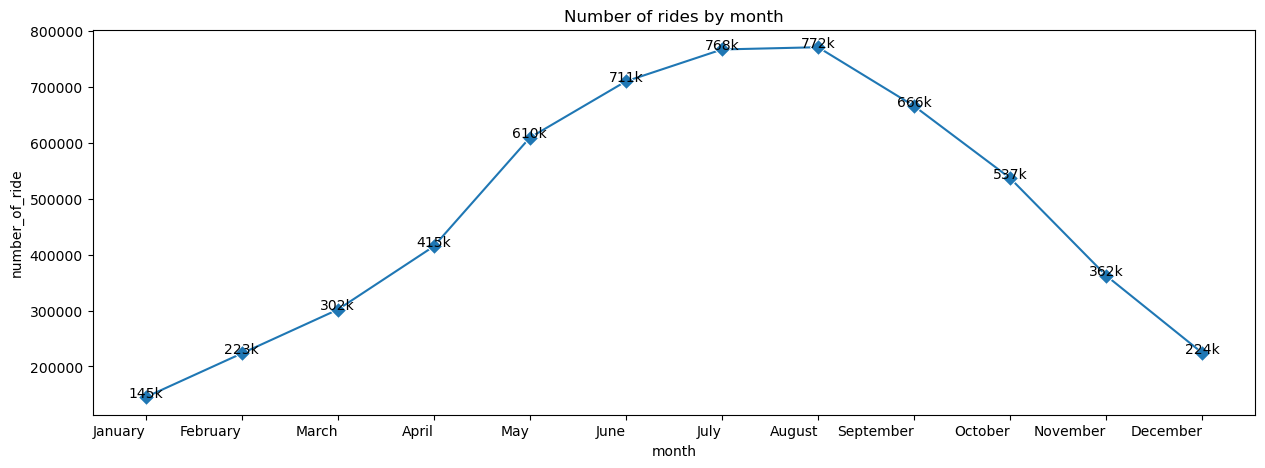

In [21]:
# plotting chart
fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(data = ride_by_month,x='month', y ='number_of_ride', marker = "D", markersize = 8)
plt.xticks(rotation=0, ha='right', fontsize=10)
for x, y in zip(ride_by_month['month'], ride_by_month['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', size = 10)
plt.title('Number of rides by month')
plt.show()


In [25]:
# ride by hours
ride_by_hr = df.groupby('time_hr').count()['ride_id'].reset_index()
ride_by_hr.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

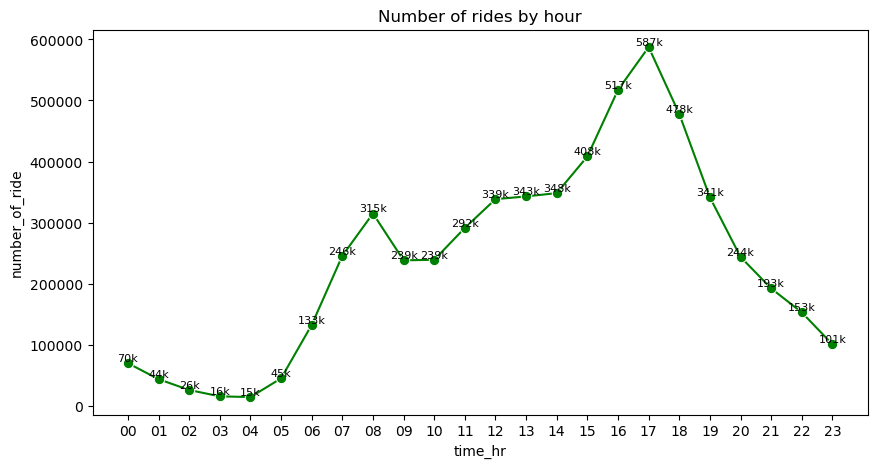

In [26]:
# plotting ride by hour
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(data = ride_by_hr,x='time_hr', y ='number_of_ride', marker = ".", markersize = 15, color = 'green')
plt.xticks(rotation=0, ha='center', fontsize=10)
for x, y in zip(ride_by_hr['time_hr'], ride_by_hr['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', va = 'bottom', size = 8)
plt.title('Number of rides by hour')
plt.show()


In [27]:
# ride by weekday
ride_by_week = df.groupby('day_of_week').count()['ride_id'].reset_index()
day_order = ['Monday','Tuesday', 'Wednesday','Thursday','Friday', 'Saturday','Sunday']
ride_by_week['day_of_week'] = pd.Categorical(ride_by_week['day_of_week'], categories=day_order, ordered= True)
ride_by_week.rename(columns={'ride_id':'number_of_ride'}, inplace=True)
ride_by_week = ride_by_week.sort_values(by='day_of_week')

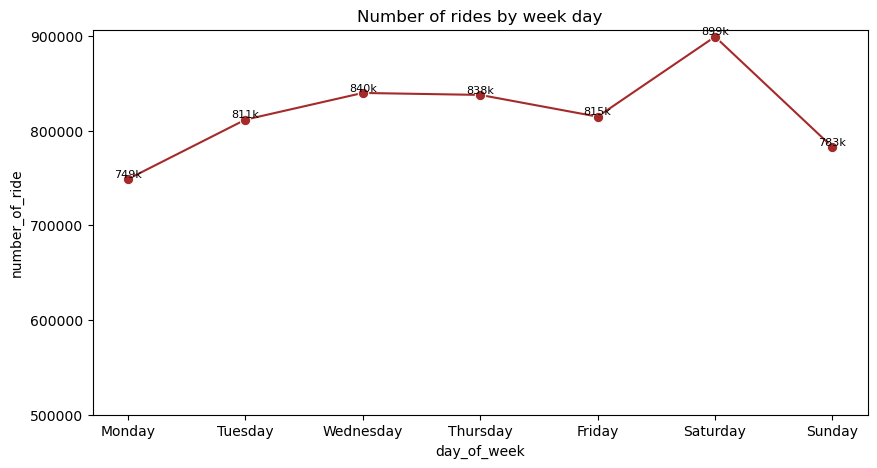

In [28]:
# plotting chart
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(data = ride_by_week,x='day_of_week', y ='number_of_ride', marker = ".", markersize = 15, color = 'brown')
plt.xticks(rotation=0, ha='center', fontsize=10)
for x, y in zip(ride_by_week['day_of_week'], ride_by_week['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', va = 'bottom', size = 8)
plt.yticks(range(500000, 1000000, 100000))
plt.title('Number of rides by week day')
plt.show()

The peak season is from June to August.
The peak hours are from 7am-8:30am and 4pm-6pm, which may match with the going-to-work and off-work hours.
The usage spread quite equally among week days and peaked during Saturday

In [29]:
df['route'] = df['start_station_id'] + '-' + df['end_station_id']

In [30]:
len(df[df['route'].isna()])

1459562

In [31]:
# indentify the most popular routes 
popular_routes = df.groupby('route').count()['ride_id'].reset_index().sort_values(by = 'ride_id', ascending=False).head(10)
popular_routes[['start_id','end_id']]  = popular_routes['route'].str.split('-', expand=True)
popular_routes.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

In [32]:
# Popular routes start locations and capacity
popular_routes = pd.merge(popular_routes, df2,left_on= 'start_id', right_on='short_name' ,how = 'left')
popular_routes = popular_routes.drop(['short_name','station_id','rental_uris','region_id','address'], axis = 1)
popular_routes.rename(columns = {'lat':'start_lat','capacity':'start_capacity','lon' :'start_lon', 'name':'start_name'}, inplace= True)

In [33]:
# popular routes end locations and capacity
popular_routes = pd.merge(popular_routes, df2,left_on= 'end_id', right_on='short_name' ,how = 'left')
popular_routes = popular_routes.drop(['short_name','station_id','rental_uris','region_id','address'], axis = 1)
popular_routes.rename(columns = {'lat':'end_lat','capacity':'end_capacity','lon' :'end_lon', 'name':'end_name'}, inplace= True)

In [34]:
popular_routes

,route,number_of_ride,start_id,end_id,start_lat,start_name,start_lon,start_capacity,end_lat,end_name,end_lon,end_capacity
0,13022-13022,9948,13022,13022,41.892278,Streeter Dr & Grand Ave,-87.612043,43,41.892278,Streeter Dr & Grand Ave,-87.612043,43
1,13300-13300,8191,13300,13300,41.880958,DuSable Lake Shore Dr & Monroe St,-87.616743,39,41.880958,DuSable Lake Shore Dr & Monroe St,-87.616743,39
2,13217-13216,5942,13217,13216,41.834900,Calumet Ave & 33rd St,-87.617930,11,41.834734,State St & 33rd St,-87.625813,15
3,13216-13217,5881,13216,13217,41.834734,State St & 33rd St,-87.625813,15,41.834900,Calumet Ave & 33rd St,-87.617930,11
4,KA1503000014-KA1504000076,5691,KA1503000014,KA1504000076,41.785097,Ellis Ave & 60th St,-87.601073,19,41.794301,Ellis Ave & 55th St,-87.601450,19
5,KA1503000014-KA1503000071,5434,KA1503000014,KA1503000071,41.785097,Ellis Ave & 60th St,-87.601073,19,41.791478,University Ave & 57th St,-87.599861,31
6,13300-13022,5303,13300,13022,41.880958,DuSable Lake Shore Dr & Monroe St,-87.616743,39,41.892278,Streeter Dr & Grand Ave,-87.612043,43
7,KA1504000076-KA1503000014,5294,KA1504000076,KA1503000014,41.794301,Ellis Ave & 55th St,-87.601450,19,41.785097,Ellis Ave & 60th St,-87.601073,19
8,13042-13042,5242,13042,13042,41.900960,Michigan Ave & Oak St,-87.623777,23,41.900960,Michigan Ave & Oak St,-87.623777,23
9,KA1503000071-KA1503000014,5175,KA1503000071,KA1503000014,41.791478,University Ave & 57th St,-87.599861,31,41.785097,Ellis Ave & 60th St,-87.601073,19


## 2. Customer behaviors:
- [ ] What are the most popular ride type?
- [ ] What are the average ride time, distance by each type of ride?
- [ ] Casual vs member: what are their preference? How is the growth rate of these 2 segments?

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733947 entries, 0 to 5734380
Data columns (total 21 columns):
 #   Column               Dtype          
---  ------               -----          
 0   ride_id              object         
 1   rideable_type        object         
 2   started_at           datetime64[ns] 
 3   ended_at             datetime64[ns] 
 4   start_station_name   object         
 5   start_station_id     object         
 6   end_station_name     object         
 7   end_station_id       object         
 8   start_lat            float64        
 9   start_lng            float64        
 10  end_lat              float64        
 11  end_lng              float64        
 12  member_casual        object         
 13  distance_km          float64        
 14  ride_length          timedelta64[ns]
 15  ride_length_minutes  float64        
 16  month                int32          
 17  time                 object         
 18  time_hr              object         
 19  day_o

In [57]:
ride_type = df.groupby('rideable_type').agg({'distance_km': 'mean', 'ride_length_minutes' : 'mean','ride_id':'count'}
                                            ).rename(columns = {'distance_km':'average_distance','ride_length_minutes':'average_time','ride_id': 'ride_number'}).reset_index()
ride_type

,rideable_type,average_distance,average_time,ride_number
0,classic_bike,1.966124,21.774149,2853856
1,docked_bike,2.168645,220.855260,34381
2,electric_bike,2.287491,12.431964,2845710


From Sep 2023, Divvy stopped their docked bike service.

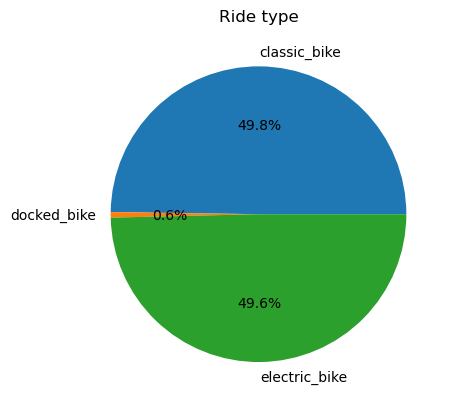

In [59]:
# ploting pie chart
fig, ax = plt.subplots()

ax.pie(ride_type['ride_number'], labels = ride_type['rideable_type'].to_list(), autopct='%1.1f%%')
ax.set_title('Ride type')

plt.show()


In [73]:
ride_by_member = df.groupby(['member_casual','rideable_type']).agg({'ride_id':'count','distance_km':'mean','ride_length_minutes':'mean'}).reset_index()

In [74]:
ride_by_member

,member_casual,rideable_type,ride_id,distance_km,ride_length_minutes
0,casual,classic_bike,964425,2.070521,35.753279
1,casual,docked_bike,34381,2.168645,220.855260
2,casual,electric_bike,1050374,2.168050,14.423067
3,member,classic_bike,1889431,1.913081,14.638762
4,member,electric_bike,1795336,2.357371,11.267055


## 3. Suggestions